<a href="https://colab.research.google.com/github/JIihoLee/schml/blob/main/%ED%85%8D%EB%A7%88%EA%B8%B0%EB%A7%90_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 9.0 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 448 kB 46.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-15 05:56:14--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt",
filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f5e982719d0>)

전체 리뷰 개수 : 200000
총 샘플의 수 : 199908
False
훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977
  label  count
0     0  27091
1     1  61818
2     2  61022


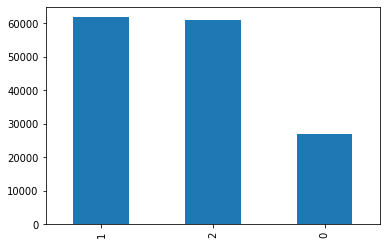

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

conditions = [total_data.ratings > 4, total_data.ratings < 2]
choices = ["2","0"]
total_data['label']= np.select(conditions, choices, default=1)

total_data[:5]
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거

print('총 샘플의 수 :',len(total_data))
print(total_data.isnull().values.any())

train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

ratings    0
reviews    0
label      0
dtype: int64
전처리 후 테스트용 샘플의 개수 : 49977
['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']
[('네요', 11653), ('안', 8369), ('는데', 8012), ('어요', 5544), ('너무', 4811), ('있', 4619), ('했', 4448), ('구매', 3838), ('없', 3682), ('배송', 3426), ('거', 3425), ('되', 3392), ('어', 3376), ('습니다', 3219), ('그냥', 3064), ('좋', 3001), ('같', 2981), ('나', 2907), ('만', 2820), ('요', 2751)]
[('네요', 11653), ('안', 8369), ('는데', 8012), ('어요', 5544), ('너무', 4811), ('있', 4619), ('했', 4448), ('구매', 3838), ('없', 3682), ('배송', 3426), ('거', 3425), ('되', 3392), ('어', 3376), ('습니다', 3219), ('그냥', 3064), ('좋', 3001), ('같', 2981), ('나', 2907), ('만', 2820), ('요', 2751)]
[('좋', 32310), ('아요', 16800), ('네요', 15511), ('잘', 15164), ('어요', 15112), ('구매', 13761), ('습니다', 10847), ('배송', 10100), ('있', 9623), ('는데', 9343), ('합니다', 8186), ('재', 7975), ('먹', 7954), ('했', 7920), ('너무', 7482), ('만족', 6042), ('같', 5748), ('쓰', 5075), ('아', 4944), ('어', 4937)]
긍정 리뷰의 평균 길이 : 1

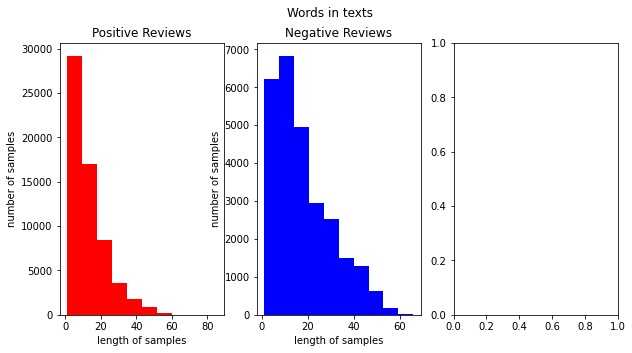

중립 리뷰의 평균 길이 : 16.175240221294768


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

 #네이버 쇼핑 리뷰 데이터의 이해
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

negative_words = np.hstack(train_data[train_data.label == '0']['tokenized'].values)
neutrality_words = np.hstack(train_data[train_data.label == '1']['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == '2']['tokenized'].values)

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

neutrality_words = Counter(negative_words)
print(neutrality_words.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
text_len = train_data[train_data['label']=='2']['tokenized'].map(lambda x: len(x))

ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']=='0']['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')

fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']== '1']['tokenized'].map(lambda x: len(x))
ax3.hist(text_len, color='green')
ax3.set_title('Neutrality Reviews')

fig.suptitle('Words in texts')
ax3.set_xlabel('length of samples')
ax3.set_ylabel('number of samples')
print('중립 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test= test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935698749320282
단어 집합의 크기 : 21787
[list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요'])
 list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요'])
 list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶'])]
[list(['너무', '낮', '솜', '적', '실망', '스럽', '습니다'])
 list(['피부', '뾰루지', '많이', '올라', '와요'])
 list(['배송', '빠르', '네요', '가격', '대비', '좋', '것', '같', '아요', '첨', '힘들', '어', '하나', '조금', '지나', '니', '잘', '네요'])]
리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307521459871541


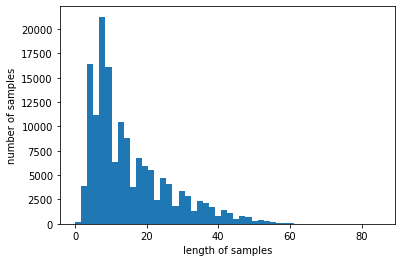

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)

print(X_train[:3])
print(X_test[:3])


print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


max_len = 80
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


NameError: ignored

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


149931

In [ ]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_split=0.2)

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

